In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_auc_score

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

shap.initjs()
%matplotlib inline

np.random.seed(3)

In [2]:
all_AGTTC=pd.read_csv('/home/jiayi/5moU/data/DL_fromTombo/all_AGTTC.csv')
all_AGTTC

,indx,kmer,mean_1,mean_2,mean_3,mean_4,mean_5,std_1,std_2,std_3,...,mdintense_2,mdintense_3,mdintense_4,mdintense_5,L-1,L-2,L-3,L-4,L-5,label
0,260,AGTTC,0.513199,0.397293,-0.850444,-0.837177,-0.786233,0.047088,0.272815,0.031234,...,0.471305,-0.846254,-0.839970,-0.768751,6,81,6,15,104,1
1,259,AGTTC,0.589209,0.568374,-0.717482,-0.762448,-0.789418,0.062266,0.080098,0.038712,...,0.579342,-0.727349,-0.763294,-0.799239,6,32,6,15,90,1
2,243,AGTTC,0.458838,0.109656,-0.797939,-0.820008,-0.756034,0.149853,0.419986,0.034345,...,0.190347,-0.796560,-0.817250,-0.755180,13,6,6,33,63,1
3,260,AGTTC,0.457595,0.472804,-0.688376,-0.681815,-0.679743,0.060894,0.174125,0.025067,...,0.513802,-0.686393,-0.686393,-0.696311,6,78,6,13,108,1
4,260,AGTTC,0.528384,0.423719,-0.713185,-0.825872,-0.800544,0.029393,0.277885,0.162593,...,0.522379,-0.768558,-0.826600,-0.792575,6,51,6,11,108,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2628,260,AGTTC,0.787659,0.405793,-0.611869,-0.739305,-0.605124,0.169036,0.279195,0.138040,...,0.463995,-0.667700,-0.744655,-0.604325,32,14,6,11,17,0
2629,161,AGTTC,0.396310,0.499622,-0.619268,-0.546544,-0.762006,0.090910,0.031997,0.130815,...,0.500937,-0.642935,-0.607435,-0.786905,39,6,6,16,16,0
2630,240,AGTTC,0.589990,0.614284,-0.632994,-0.789089,-0.753708,0.172348,0.280588,0.188418,...,0.688070,-0.685807,-0.796713,-0.751445,6,40,6,19,6,0
2631,260,AGTTC,0.661435,0.551367,-0.694797,-0.734620,-0.571503,0.110638,0.231089,0.049018,...,0.548295,-0.676666,-0.739763,-0.576580,33,34,6,11,6,0


In [3]:
kfolds = KFold(n_splits=5, shuffle=True)

param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.2,
    'silent': 1,
    'nthreads': 2,
}

num_round = 10

thres = 0.5

In [4]:
features = ['mean_1', 'mean_2', 'mean_3', 'mean_4', 'mean_5',
        'std_1', 'std_2', 'std_3', 'std_4', 'std_5', 'mdintense_1',
        'mdintense_2', 'mdintense_3', 'mdintense_4', 'mdintense_5', 'L-1',
        'L-2', 'L-3', 'L-4', 'L-5']
target = 'label'

#X = dataset[features]
X=all_AGTTC.iloc[:,2:all_AGTTC.shape[1]-1]
y = all_AGTTC[target]

In [5]:
cnf = list()
auc = list()

for train_idx, test_idx in kfolds.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    param['scale_pos_weight'] = (y_train.size - y_train.sum()) / y_train.sum()    
    
    xg_train = xgb.DMatrix(
        X_train.values, feature_names=features, label=y_train.values
    )
    xg_test = xgb.DMatrix(
        X_test.values, feature_names=features, label=y_test.values
    )
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    bst = xgb.train(param, xg_train, num_round, watchlist, verbose_eval=False)
    preds = bst.predict(xg_test)
    
    cnf.append(confusion_matrix(y_test, (preds > thres).astype(int)))
    auc.append(roc_auc_score(y_test, preds))
    
cnf = sum(cnf)
auc = sum(auc) / len(auc)

'Average AUC: {:.04f}'.format(auc)    

[11:08:40] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[11:08:40] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[11:08:40] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[11:08:40] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[11:08:40] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.



Pass `evals` as keyword args.
Pass `evals` as keyword args.
Pass `evals` as keyword args.
Pass `evals` as keyword args.
Pass `evals` as keyword args.


'Average AUC: 0.9933'

Text(58.222222222222214, 0.5, 'Observation')

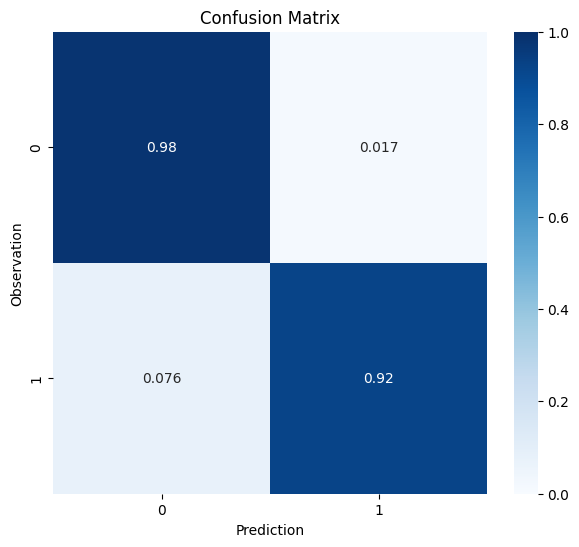

In [6]:
fig, ax = plt.subplots(figsize=(7, 6))

normalized_cnf = cnf / cnf.sum(axis=1).reshape(-1, 1)

sns.heatmap(normalized_cnf, annot=True, cmap="Blues", ax=ax, vmin=0, vmax=1)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation')

In [7]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


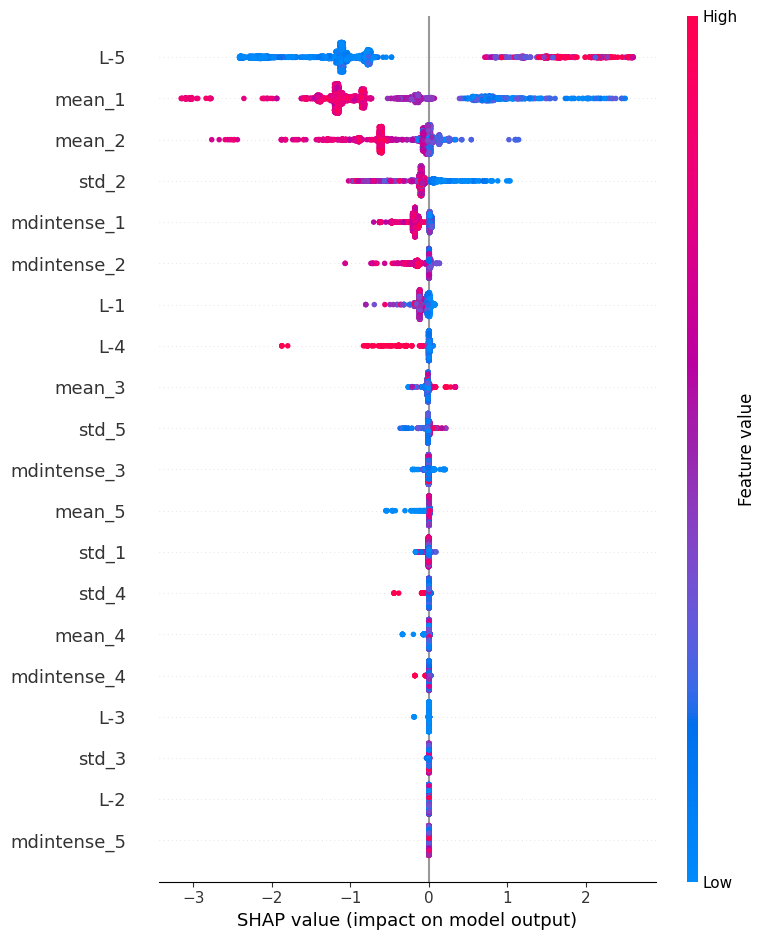

In [8]:
shap.summary_plot(shap_values, X)